### LASSO parameter range experiments: microsatellite instability (MSI) prediction

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [3]:
ll_base_results_dir = os.path.join(
    cfg.repo_root, '10_msi_prediction', 'results', 'msi_lasso_range_sex_covariate_lr'
)

# this doesn't have a sex covariate but it's probably close enough
sgd_base_results_dir = os.path.join(
    cfg.repo_root, '10_msi_prediction', 'results', 'msi_lasso_range'
)

training_dataset = 'all_other_cancers'
ll_results_dir = os.path.join(ll_base_results_dir, training_dataset)
sgd_results_dir = os.path.join(sgd_base_results_dir, training_dataset)

metric = 'aupr'
nz_cutoff = 5.0

output_plots = False
output_plots_dir = None

### Get coefficient information for each lasso penalty

In [4]:
ll_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range_msi(ll_results_dir):
    (cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_nz_coefs_df.append(
            [cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
ll_nz_coefs_df = pd.DataFrame(
    ll_nz_coefs_df,
    columns=['cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)
ll_nz_coefs_df.head()

,cancer_type,lasso_param,seed,fold,nz_coefs
0,UCEC,0.001,42,0,0
1,UCEC,0.001,42,1,0
2,UCEC,0.001,42,2,0
3,UCEC,0.001,42,3,0
4,UCEC,1500.000,1,0,8392


In [6]:
sgd_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range_msi(sgd_results_dir):
    (cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_nz_coefs_df.append(
            [cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
sgd_nz_coefs_df = pd.DataFrame(
    sgd_nz_coefs_df,
    columns=['cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)
sgd_nz_coefs_df.head()

,cancer_type,lasso_param,seed,fold,nz_coefs
0,UCEC,1.000000e-08,1,0,16149
1,UCEC,1.000000e-08,1,1,16149
2,UCEC,1.000000e-08,1,2,16149
3,UCEC,1.000000e-08,1,3,16149
4,COAD,1.000000e-08,1,0,16149


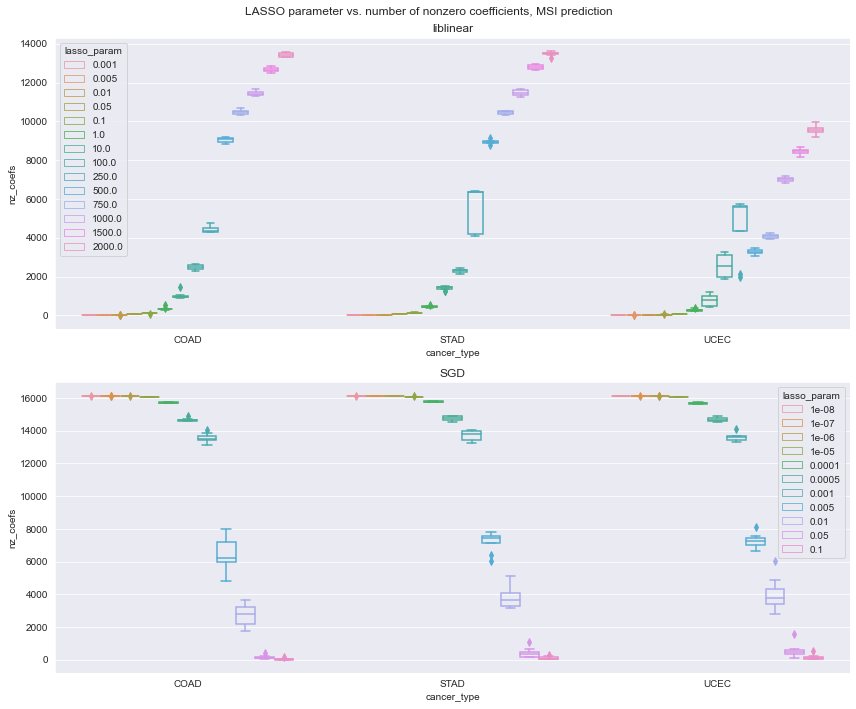

In [7]:
sns.set({'figure.figsize': (12, 10)})
fig, axarr = plt.subplots(2, 1)

def color_boxplot_edges(ax):
    # color the boxplot lines/edges rather than the box fill
    # this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
    # https://stackoverflow.com/a/72333641
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers

    # also fix the legend to color the edges rather than fill
    for legpatch in ax.legend_.get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor(col)
        legpatch.set_facecolor('None')


sns.boxplot(
    data=ll_nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param', ax=axarr[0]
)
color_boxplot_edges(axarr[0])
axarr[0].set_title('liblinear')

sns.boxplot(
    data=sgd_nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param', ax=axarr[1]
)
color_boxplot_edges(axarr[1])
axarr[1].set_title('SGD')


plt.suptitle(f'LASSO parameter vs. number of nonzero coefficients, MSI prediction')
plt.tight_layout()